In [249]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.core.brain_observatory_nwb_data_set import BrainObservatoryNwbDataSet
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
import os
# import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore, spearmanr, pearsonr
from tqdm import tqdm


In [ ]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [2]:
filter_json = """
[
    {
        "field": "area",
        "op": "in",
        "value": [
            "VISp"
        ]
    },
    {
        "field": "tld1_name",
        "op": "in",
        "value": [
            "Cux2-CreERT2",
            "Slc17a7-IRES2-Cre"
        ]
    }
]
"""
       
filters = json.loads(filter_json)
boc = BrainObservatoryCache(manifest_file="brain_observatory/manifest.json")
cells = boc.get_cell_specimens(filters=filters)
cells_df = pd.DataFrame(cells)
cells_df

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
0,False,VISp,517406367,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,511507650,False,NaN,NaN,0.683686,...,495727026,NaN,0.26600,0.33250,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
1,False,VISp,517406379,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,511507650,False,NaN,NaN,0.788170,...,495727026,NaN,0.29925,0.29925,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
2,False,VISp,517406391,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,0.877959,511507650,False,0.507377,0.127260,NaN,...,495727026,0.438380,NaN,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
3,False,VISp,517406400,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,511507650,False,NaN,NaN,0.498305,...,495727026,NaN,0.26600,0.36575,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
4,False,VISp,517406405,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,511507650,False,NaN,NaN,NaN,...,495727026,NaN,NaN,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,False,VISp,738949207,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,0.533129,712178509,False,0.273694,0.247268,0.825973,...,699502603,0.360599,0.29844,0.36476,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
11336,False,VISp,738949239,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,712178509,False,NaN,NaN,0.289035,...,699502603,NaN,0.29844,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
11337,False,VISp,738949290,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,712178509,False,NaN,NaN,NaN,...,699502603,NaN,NaN,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
11338,False,VISp,738949318,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,0.562188,712178509,False,0.158478,0.242484,NaN,...,699502603,0.361589,NaN,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)


In [9]:
# cells_df.columns.unique().tolist()
# cont_ids = cells_df['experiment_container_id'].unique()
# experiments = boc.get_ophys_experiments(experiment_container_ids=cont_ids, include_failed=False, require_eye_tracking=False)
# exp_ids = [d['id'] for d in experiments]
# exp_ids = exp_ids[:30]
# exp_ids[-1]

510517131

In [3]:
saving_dir = r'D:\BrainObservatory\brain_observatory\ophys_experiment_data'
files = os.listdir(saving_dir)
exp_ids = [int(s[:-4]) for s in files]
exp_ids

[647155122,
 650389887,
 650512363,
 652094901,
 652842572,
 653053207,
 653125130,
 653173685,
 654920038,
 656381309,
 656939127,
 657082055,
 657469734,
 657649672,
 661437140,
 662107986,
 663479950,
 663485329,
 663868345,
 663873076,
 664404274,
 667364442,
 667376208,
 680156911,
 681673022,
 681674286,
 685494041,
 688678766,
 690045763]

In [4]:
bad_ids = []
for exp in tqdm(exp_ids):
    # boc.get_ophys_experiment_data(exp)
    try:
        boc.get_ophys_pupil_data(exp,  suppress_pupil_data=False)
    except Exception:
        bad_ids.append(exp)
exp_ids = [id for id in exp_ids if id not in bad_ids]

100%|██████████| 29/29 [00:05<00:00,  5.72it/s]


In [490]:
n =23


id = exp_ids[n]
exp  = boc.get_ophys_experiment_data(id)
dff = exp.get_dff_traces()
calcium = zscore(dff[1], axis = 0, ddof=1, nan_policy='omit')
eye = boc.get_ophys_pupil_data(id, suppress_pupil_data=False)
stim = boc.get_ophys_experiment_stimuli(id)



In [451]:
spont = exp.get_stimulus_table('spontaneous').values[0]
spont

array([66772, 75680])

In [452]:
ts = dff[0][spont[0]:spont[1]]

In [453]:
eye_ts = (find_nearest(eye.index.tolist(), ts[0]), find_nearest(eye.index.tolist(), ts[-1]))
eye_sp = eye.loc[eye_ts[0]:eye_ts[1]]
eye_sp

,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg,filtered_eye_area,filtered_pupil_area,filtered_screen_coordinates_x_cm,filtered_screen_coordinates_y_cm,filtered_screen_coordinates_spherical_x_deg,filtered_screen_coordinates_spherical_y_deg
2227.33944,17990.841912,249.172982,32.204113,7.632209,12.103245,2.913103,17990.841912,249.172982,32.204113,7.632209,12.103245,2.913103
2227.37266,17955.539196,246.187932,32.213291,8.831067,12.101455,3.369706,17955.539196,246.187932,32.213291,8.831067,12.101455,3.369706
2227.40593,17791.093058,231.074381,31.879573,8.805182,11.979846,3.359852,17791.093058,231.074381,31.879573,8.805182,11.979846,3.359852
2227.44063,17997.818744,252.796111,32.039523,8.389512,12.040054,3.201580,17997.818744,252.796111,32.039523,8.389512,12.040054,3.201580
2227.47354,17656.596284,240.432397,32.458406,8.015343,12.194394,3.059069,17656.596284,240.432397,32.458406,8.015343,12.194394,3.059069
...,...,...,...,...,...,...,...,...,...,...,...,...
2523.40124,17400.867826,158.323345,32.019180,15.489464,11.988986,5.896299,17400.867826,158.323345,32.019180,15.489464,11.988986,5.896299
2523.43615,17442.670333,167.497748,31.126336,15.785927,11.661650,6.008334,17442.670333,167.497748,31.126336,15.785927,11.661650,6.008334
2523.46852,17222.661270,175.276682,30.206871,15.529184,11.328153,5.911312,17222.661270,175.276682,30.206871,15.529184,11.328153,5.911312
2523.50191,17390.330949,158.693438,31.695851,15.469791,11.871528,5.888863,17390.330949,158.693438,31.695851,15.469791,11.871528,5.888863


In [454]:
ts[-1] -eye_ts[-1]

0.015409999999974389

In [455]:
new_pupil = np.interp(ts, eye_sp.index.to_list(),  eye_sp['filtered_pupil_area'])
nans, x= nan_helper(new_pupil)
new_pupil[nans]= np.interp(x(nans), x(~nans), new_pupil[~nans])
new_pupil_1 = new_pupil.copy()
new_pupil = pd.Series(new_pupil).rolling(60, min_periods=1).median().values

new_pupil = zscore(new_pupil, ddof=1, nan_policy = 'omit')
new_pupil_1 = zscore(new_pupil_1, ddof=1, nan_policy = 'omit')




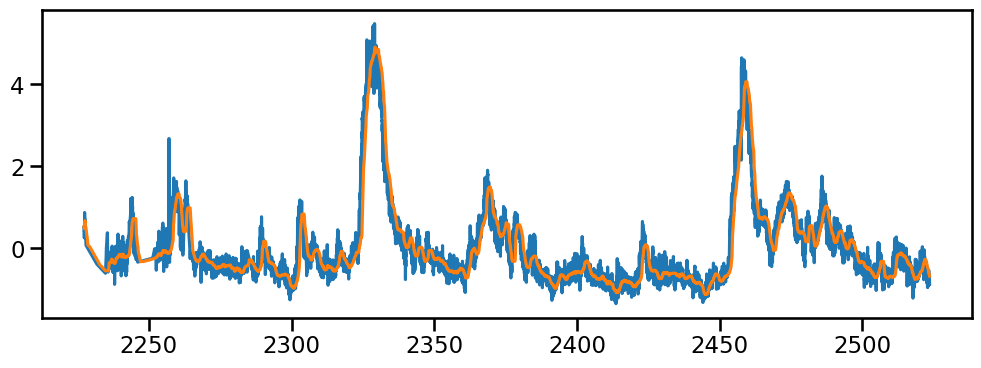

In [456]:
%matplotlib inline
plt.figure(figsize= (12,4))
plt.plot(ts, new_pupil_1)
plt.plot(ts, new_pupil)

# 
# plt.plot(eye_sp.index.tolist(), eye_sp['raw_pupil_area'])

In [457]:
traces = calcium[:,spont[0] : spont[-1]]
traces


array([[-0.43906894, -1.0789064 , -0.56545186, ...,  0.14629902,
        -1.2459924 , -0.96696955],
       [ 0.6017792 ,  0.51473093,  0.71167886, ..., -0.90469223,
         0.4489069 ,  0.5820563 ],
       [ 0.24209188,  0.5373262 , -0.3975555 , ...,  0.8827496 ,
        -0.04925624, -0.6518952 ],
       ...,
       [-0.47574025,  0.6034641 , -0.9145394 , ..., -0.06195097,
         0.29250062,  0.42519033],
       [-0.39710042,  0.7112544 ,  0.7819668 , ..., -0.34833747,
         1.3290175 , -0.88937145],
       [-0.18360108, -0.5042266 , -0.05329557, ...,  0.5387012 ,
         0.23238958,  0.87441605]], dtype=float32)

In [458]:
traces.shape

(261, 8908)

In [459]:
pca = PCA()

components = pca.fit_transform(traces.T)
scree1 = np.cumsum(pca.explained_variance_ratio_)

pca.explained_variance_ratio_



array([3.18748169e-02, 1.78545117e-02, 1.72517467e-02, 1.46867549e-02,
       1.40701486e-02, 1.34451054e-02, 1.26561802e-02, 1.17732026e-02,
       1.09039191e-02, 1.06867496e-02, 1.04694655e-02, 9.73992515e-03,
       9.33162682e-03, 9.27271042e-03, 8.88376124e-03, 8.03372078e-03,
       7.87709653e-03, 7.63752824e-03, 7.43526779e-03, 7.27095781e-03,
       6.83669560e-03, 6.69325422e-03, 6.60391711e-03, 6.54175878e-03,
       6.33681612e-03, 6.23995252e-03, 6.17026677e-03, 6.04704954e-03,
       5.99944452e-03, 5.92909195e-03, 5.82699664e-03, 5.75331738e-03,
       5.69185661e-03, 5.60794864e-03, 5.57658589e-03, 5.44249639e-03,
       5.42718312e-03, 5.35085145e-03, 5.31030353e-03, 5.20365778e-03,
       5.14341751e-03, 5.08581614e-03, 5.01458766e-03, 4.92568035e-03,
       4.87459777e-03, 4.85291937e-03, 4.83556092e-03, 4.75607021e-03,
       4.73351404e-03, 4.62020049e-03, 4.60461155e-03, 4.55952575e-03,
       4.50244546e-03, 4.48095519e-03, 4.45912685e-03, 4.40232549e-03,
      

Text(0.5, 0, 'Number of components')

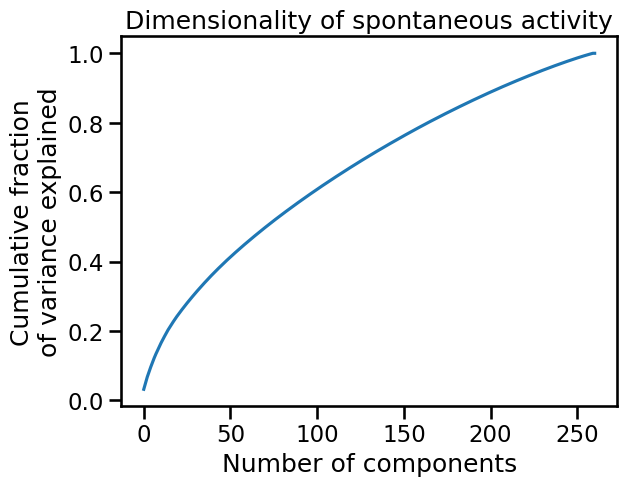

In [460]:
sns.set_context('talk')
f, ax = plt.subplots()

sns.lineplot(scree1)


ax.set_title('Dimensionality of spontaneous activity')
ax.set_ylabel('Cumulative fraction\nof variance explained')
ax.set_xlabel('Number of components')

In [462]:
dff_0 = traces[:,:-300].T
dff_1 = traces[:,-300:].T
eye_0 = new_pupil[:-300]
eye_1 = new_pupil[-300:]
train_dff, test_dff, train_pupil, test_pupil = train_test_split(dff_0, eye_0, random_state=42)

In [463]:
lr = LinearRegression()

lr.fit(train_dff, train_pupil)

LinearRegression()

In [464]:
pupil_pred = lr.predict(dff_1)

mean_squared_error(eye_1,pupil_pred)

1.3939902693285595

In [465]:
r2_score(eye_1,pupil_pred)

-37.29688995591046

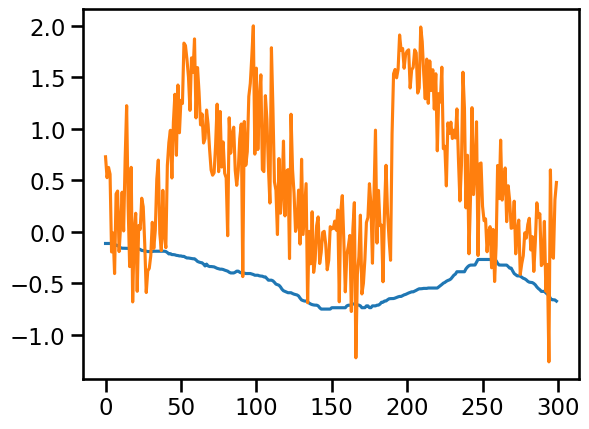

In [466]:
plt.plot(eye_1)
plt.plot(pupil_pred)

0.22144317390440083


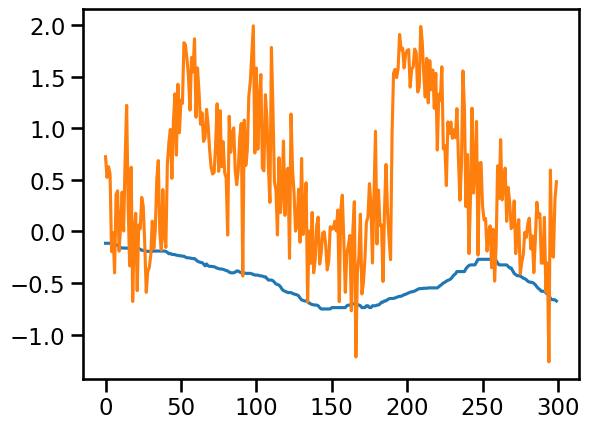

In [467]:
r = Ridge(alpha=10, random_state = 42)

r.fit(train_dff, train_pupil)
pupil_pred = r.predict(dff_1)
print(r.score(test_dff, test_pupil))
plt.plot(eye_1)
plt.plot(pupil_pred)

In [468]:
l = Lasso(random_state = 42)

l.fit(train_dff, train_pupil)
pupil_pred = l.predict(dff_1)
l.score(test_dff, test_pupil)

-0.00023383220284900474

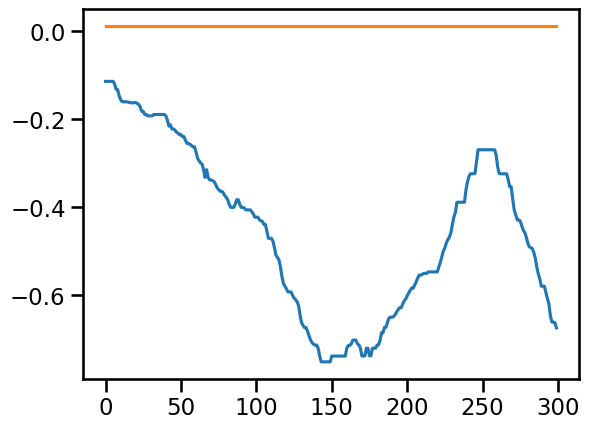

In [469]:
plt.plot(eye_1)
plt.plot(pupil_pred)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   53.9s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.0s finished


0.5020663152339995


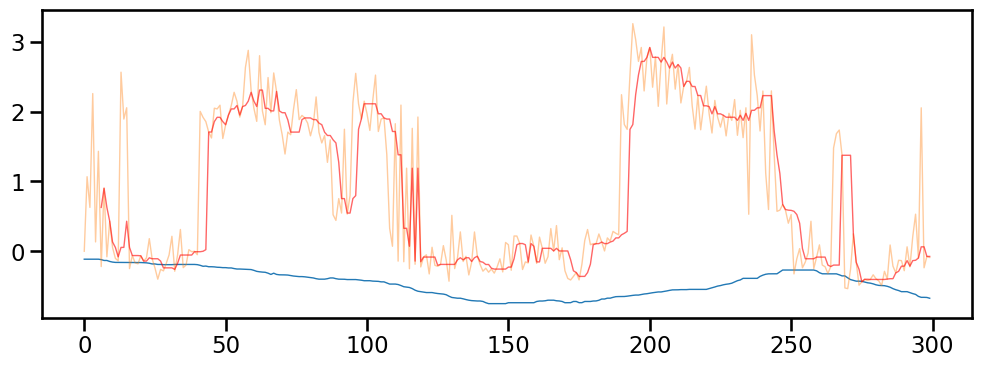

In [470]:
rf = RandomForestRegressor(n_estimators =300, random_state = 42, oob_score = True, n_jobs  =12, verbose = True)

rf.fit(train_dff, train_pupil)
pupil_pred = rf.predict(dff_1)
print(rf.score(test_dff, test_pupil))

plt.subplots(figsize =  (12, 4))
plt.plot(eye_1 ,linewidth = 1, alpha = .99)
plt.plot(pupil_pred, linewidth = 1, alpha = .4)
plt.plot(pd.Series(pupil_pred).rolling(7).median() ,linewidth = 1, alpha = .6, color = 'r')

In [471]:
r, p = spearmanr(components[:,0], new_pupil)


r**2

0.0007157245917392443

In [472]:
p>0.05

False

In [473]:
eye_xpos = np.interp(ts, eye_sp.index.to_list(),  eye_sp['filtered_screen_coordinates_spherical_x_deg'])
nans, x= nan_helper(eye_xpos)
eye_xpos[nans]= np.interp(x(nans), x(~nans), eye_xpos[~nans])
eye_xpos_1 = eye_xpos.copy()
eye_xpos = pd.Series(eye_xpos).rolling(30, min_periods=1).median().values

eye_xpos = zscore(eye_xpos, ddof=1, nan_policy = 'omit')
eye_xpos_1 = zscore(eye_xpos_1, ddof=1, nan_policy = 'omit')

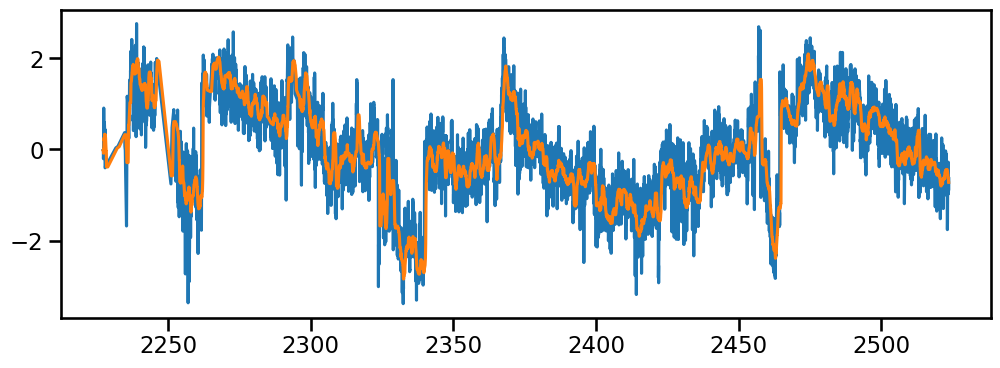

In [474]:
%matplotlib inline
plt.figure(figsize= (12,4))
plt.plot(ts, eye_xpos_1)
plt.plot(ts, eye_xpos)

In [475]:
eyex_0 = eye_xpos_1[:-300]
eyex_1 = eye_xpos_1[-300:]
train_dff, test_dff, train_x, test_x = train_test_split(dff_0, eyex_0, random_state=42)

0.08180063864363551


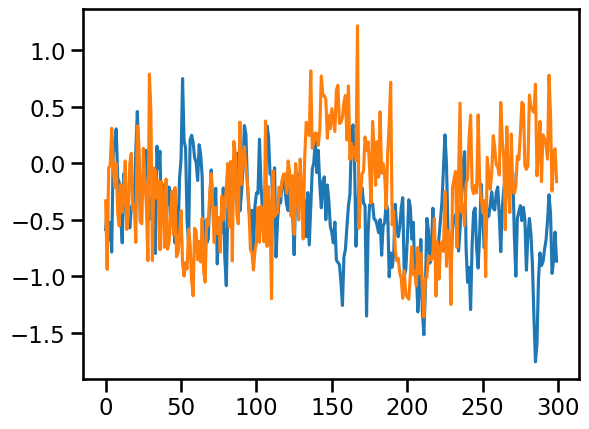

In [476]:
r = Ridge(alpha=1, random_state = 42)

r.fit(train_dff, train_x)
x_pred = r.predict(dff_1)
print(r.score(test_dff, test_x))
plt.plot(eyex_1)
plt.plot(x_pred)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   15.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished


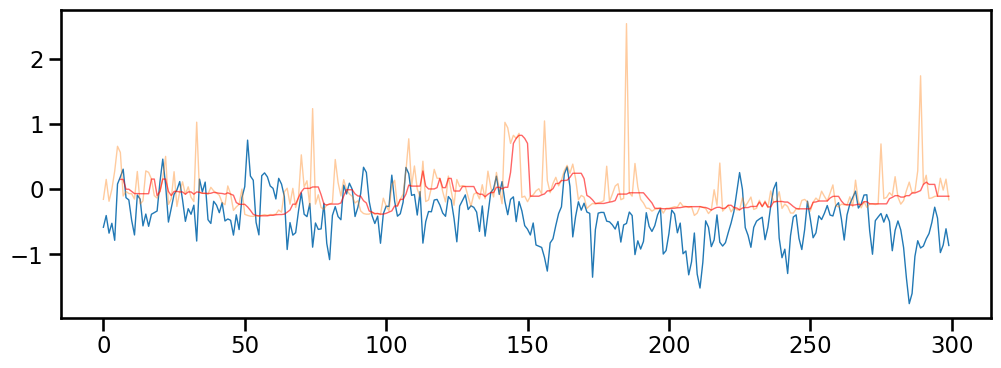

In [538]:
rf = RandomForestRegressor(n_estimators =400, random_state = 42, oob_score = True, n_jobs  =12, verbose = True)

rf.fit(train_dff, train_x)
x_pred = rf.predict(dff_1)
rf.score(test_dff, test_x)

plt.subplots(figsize =  (12, 4))
plt.plot(eyex_1 ,linewidth = 1, alpha = .99)
plt.plot(x_pred, linewidth = 1, alpha = .4)
plt.plot(pd.Series(x_pred).rolling(7).median() ,linewidth = 1, alpha = .6, color = 'r')

In [507]:
speed = exp.get_running_speed()


NoEyeTrackingException: No pupil tracking for this experiment.

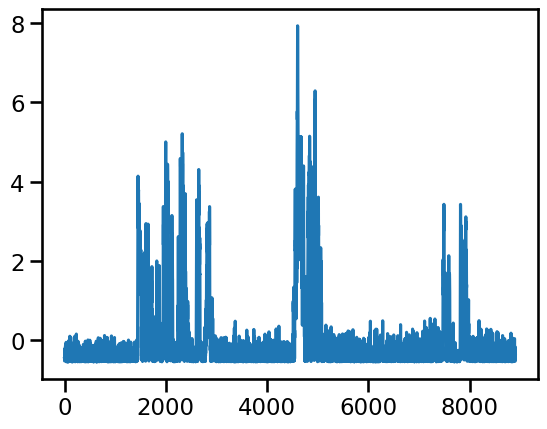

In [529]:
abs_speed = zscore(np.abs(speed[0][spont[0]:spont[1]]), ddof = 1)
plt.plot(abs_speed)
r, p = spearmanr(components[:,0], abs_speed)


In [528]:
speed = speed[spont[0]:spont]

0.06061061277445343

In [533]:
run_0 = abs_speed[:-300]
run_1 = abs_speed[-300:]
train_dff, test_dff, train_run, test_run = train_test_split(dff_0, run_0, random_state=42)

0.025535002569167742


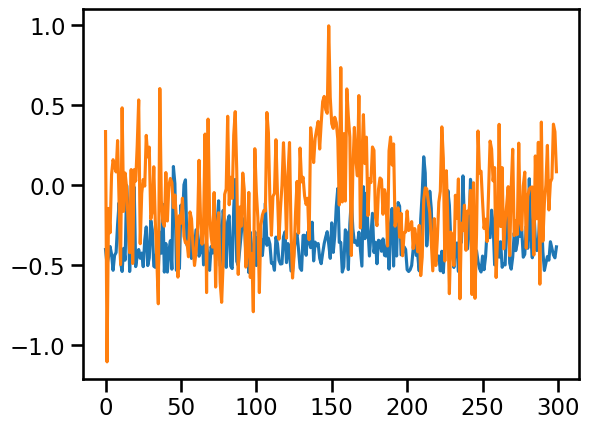

In [536]:
r = Ridge(alpha=15, random_state = 42)

r.fit(train_dff, train_run)
run_pred = r.predict(dff_1)
print(r.score(test_dff, test_run))
plt.plot(run_1)
plt.plot(run_pred)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   15.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished


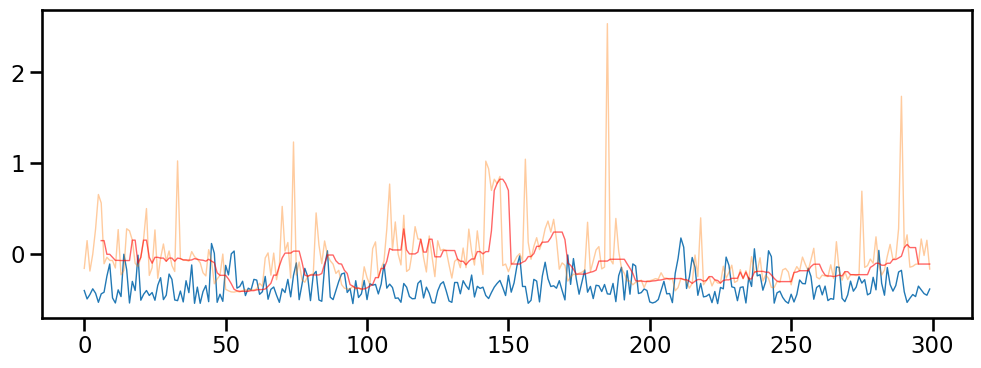

In [539]:
rf = RandomForestRegressor(n_estimators =400, random_state = 42, oob_score = True, n_jobs  =12, verbose = True)

rf.fit(train_dff, train_run)
run_pred = rf.predict(dff_1)
rf.score(test_dff, test_run)

plt.subplots(figsize =  (12, 4))
plt.plot(run_1 ,linewidth = 1, alpha = .99)
plt.plot(run_pred, linewidth = 1, alpha = .4)
plt.plot(pd.Series(run_pred).rolling(7).median() ,linewidth = 1, alpha = .6, color = 'r')